In [4]:
# google drive
# from google.colab import drive
# drive.mount('/content/drive')
# file address in google drive
file_root = './'

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights

In [13]:
import torch_dct as dct

In [11]:
def pltshow(img,gray=False):
    plt.figure(figsize=(5,5))
    plt.axis('off')
    if(gray):
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img)
toPIL = transforms.ToPILImage()

In [15]:
# load and show original image
img = cv2.imread('%sbeagle.jpg'%file_root)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# load and show watermark image
wm = cv2.imread('%secnu.jpg'%file_root)
wm = cv2.cvtColor(wm,cv2.COLOR_BGR2RGB)
wm = cv2.resize(wm,dsize=(img.shape[1],img.shape[0]),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)

In [16]:
# image tranformation
T_3 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize([256,256]),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
T_2 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize([256,256])
])
T = transforms.ToTensor()

img_tensor =  T(img)
img_tensor = img_tensor.cuda()
wm_tensor = T(wm)
wm_tensor = wm_tensor.cuda()

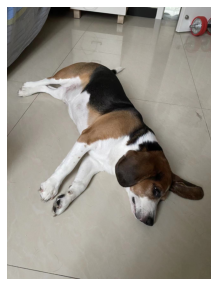

In [17]:
pltshow(toPIL(img_tensor))

In [32]:
alpha=0.1

In [33]:
wmed_tensor = embed_wm(img_tensor,wm_tensor,alpha)

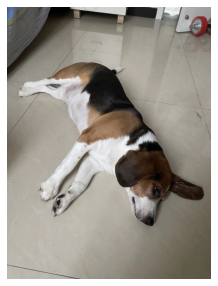

In [34]:
pltshow(toPIL(wmed_tensor))

In [36]:
from torch import Tensor
from torchvision.models.resnet import ResNet
from torch import nn
from typing import Optional, Any, List, Callable, Type, Union
from torchvision.models.resnet import BasicBlock,Bottleneck
class ResNet_with_trans(ResNet):
    def forward(self, x: Tensor) -> Tensor:
        x = transforms.Resize([256,256])(x)
        x = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(x)
        return self._forward_impl(x)

from torchvision.models.resnet import ResNet50_Weights
from torchvision.models._utils import _ovewrite_named_param
def resnet50_with_trans(*, weights: Optional[ResNet50_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:
    weights = ResNet50_Weights.verify(weights)
    # model = _resnet(Bottleneck, [3, 4, 6, 3], weights, progress, **kwargs)
    block = Bottleneck
    layers = [3, 4, 6, 3]

    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet_with_trans(block, layers, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress))
    
    return model

In [37]:
resnet = resnet50_with_trans(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet = resnet.cuda()
resnet = resnet.eval()

In [132]:
# check classification result for single image
# param model: torch model
# param img: 4-dim image tensor
def check_classify(model,img):
    img = torch.unsqueeze(img,0).type(torch.FloatTensor).cuda()
    out = (F.softmax(model(img),dim=1))
    print(torch.max(out))
    print(out.argmax())

In [43]:
check_classify(resnet,img_tensor)

tensor(0.7204, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(162, device='cuda:0')


In [44]:
check_classify(resnet,wmed_tensor)

tensor(0.7207, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(162, device='cuda:0')


In [45]:
target = torch.tensor([162]).cuda()

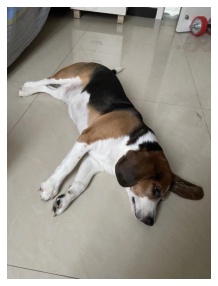

In [52]:
pltshow(toPIL(pgd_wmed))

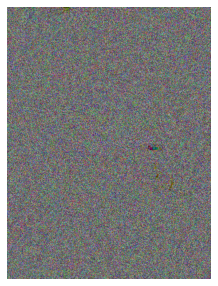

In [55]:
pltshow(toPIL(pgd_wmed-wmed_tensor))

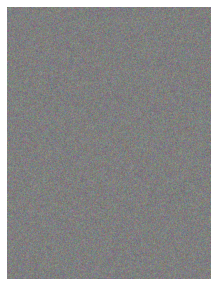

In [53]:
pltshow(toPIL(extract_wm(img_tensor,pgd_wmed,alpha)))

In [54]:
cw_atk = torchattacks.CW(resnet, c=1, kappa=0, steps=1000, lr=0.01)
cw_images = cw_atk(wmed_input, target)
out_per = (F.softmax(resnet(cw_images),dim=1))
print(torch.max(out_per))
print(out_per.argmax())
cw_wmed = cw_images[0,...]

tensor(0.4410, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(166, device='cuda:0')


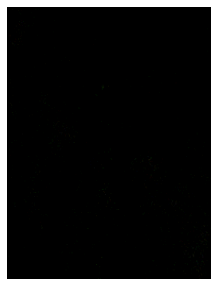

In [56]:
pltshow(toPIL(cw_wmed-wmed_tensor))

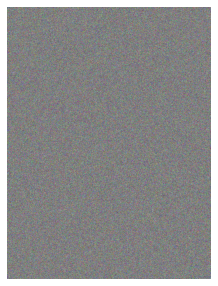

In [59]:
pltshow(toPIL(extract_wm(img_tensor,cw_wmed,alpha)))

In [60]:
noise = torch.rand_like(img_tensor)

after_noise = wmed_tensor + 0.1*noise

pltshow(toPIL(extract_wm(img_tensor,wmed_tensor,alpha)))

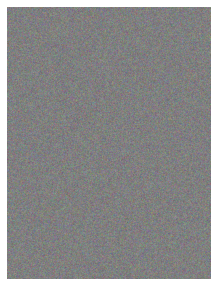

In [64]:
pltshow(toPIL(extract_wm(img_tensor,after_noise,alpha)))

In [66]:
# add border to image so that it can be divided perfectly with block_size
def addborder(img,block_size=8):
    diff_x = img.shape[0] % block_size
    diff_y = img.shape[1] % block_size
    if (diff_x==0 and diff_y==0):
        return img
    img = cv2.copyMakeBorder(img,
              0,(block_size-diff_x),
              0,(block_size-diff_y),
              cv2.BORDER_REPLICATE)
    return img

In [70]:
img = addborder(img)
img_tensor = T(img).cuda()
wm = cv2.resize(wm,dsize=(img.shape[1],img.shape[0]),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)
wm_tensor = T(wm).cuda()

In [73]:
%%time
test = cv2.dct(img[...,0].astype(np.float64))

CPU times: user 72.5 ms, sys: 10.2 ms, total: 82.7 ms
Wall time: 78.9 ms


In [74]:
%%time
test = dct.dct_2d(img_tensor[0,...])

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 2.79 ms


In [87]:
%%time
test = cv2.dct(img[:8,:8,0].astype(np.float64))

CPU times: user 2.27 ms, sys: 117 µs, total: 2.39 ms
Wall time: 1.14 ms


In [86]:
%%time
test = cv2.dct(img_tensor[0,:8,:8].cpu().numpy())

CPU times: user 3.79 ms, sys: 195 µs, total: 3.99 ms
Wall time: 1.82 ms


In [85]:
res = img_tensor[0,:8,:8].cpu().numpy()

In [88]:
from tqdm import tqdm

In [116]:
def block_dct(bk,block_size=8):
    img_dct_blocks_h = bk.shape[0] // block_size
    img_dct_blocks_w = bk.shape[1] // block_size
    img_dct = np.zeros(shape = (bk.shape[0],bk.shape[1]))
    with tqdm(total=img_dct_blocks_h*img_dct_blocks_w) as pbar:
        pbar.set_description('DCT Processing')
        for h in range(img_dct_blocks_h):
            for w in range(img_dct_blocks_w):
                a_block = bk[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size]
                img_dct[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size] =\
                cv2.dct(a_block.cpu().numpy())
                pbar.update(1)
    return torch.from_numpy(img_dct).cuda()

def block_idct(bk,block_size=8):
    img_dct_blocks_h = bk.shape[0] // block_size
    img_dct_blocks_w = bk.shape[1] // block_size
    img_idct = np.zeros(shape = (bk.shape[0],bk.shape[1]))
    with tqdm(total=img_dct_blocks_h*img_dct_blocks_w) as pbar:
        pbar.set_description('IDCT Processing')
        for h in range(img_dct_blocks_h):
            for w in range(img_dct_blocks_w):
                a_block = bk[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size]
                img_idct[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size] =\
                cv2.idct(a_block.cpu().numpy())
                pbar.update(1)
    return torch.from_numpy(img_idct).cuda()

def dct_tensor(img):
    return torch.stack((block_dct(img[0,...]),block_dct(img[1,...]),block_dct(img[2,...])),dim=0)

def idct_tensor(img):
    return torch.stack((block_idct(img[0,...]),block_idct(img[1,...]),block_idct(img[2,...])),dim=0)

def embed_wm(img,wm,alpha):
    img_dct = dct_tensor(img)
    img_dct_wm = img_dct + alpha*wm
    img_wm_idct = idct_tensor(img_dct_wm)
    wmed_img = img_wm_idct.clip(0,1)
    return wmed_img

def extract_wm(img,wmed_img,alpha):
    img_dct = dct_tensor(img)
    wmed_dct = dct_tensor(wmed_img)
    wm = (wmed_dct-img_dct)/alpha
    return wm

In [94]:
dct_block_img = dct_tensor(img_tensor)

DCT Processing:: 100%|██████████████████████████████████████████████████████████| 34240/34240 [00:05<00:00, 5750.82it/s]


In [96]:
idct_block_img = idct_tensor(dct_block_img)

IDCT Processing:: 100%|███████████████████████████████████████████████████████| 34240/34240 [00:00<00:00, 196126.94it/s]


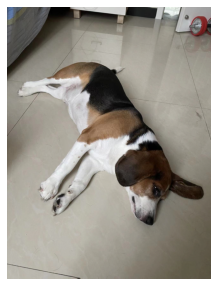

In [97]:
pltshow(toPIL(idct_block_img))

In [115]:
alpha = 0.05
wmed = embed_wm(img_tensor,wm_tensor,alpha)

IDCT Processing:: 100%|█████████████████████████████████████████████████████████| 34240/34240 [00:06<00:00, 5050.59it/s]


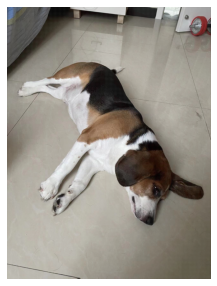

In [106]:
pltshow(toPIL(wmed))

DCT Processing: 100%|███████████████████████████████████████████████████████████| 34240/34240 [00:06<00:00, 5088.23it/s]


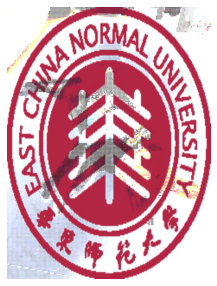

In [119]:
pltshow(toPIL(extract_wm(img_tensor,wmed,alpha)))

DCT Processing: 100%|███████████████████████████████████████████████████████████| 34240/34240 [00:06<00:00, 5093.16it/s]


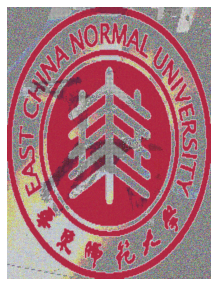

In [120]:
noise = torch.rand_like(img_tensor)
after_noise = wmed+ 0.01*noise
pltshow(toPIL(extract_wm(img_tensor,after_noise,alpha)))

In [121]:
import torchattacks
beta = 1/255
pgd_atk = torchattacks.PGD(resnet, eps=8/255, alpha=beta, steps=40, random_start=True)
wmed_input = torch.unsqueeze(wmed,0).type(torch.FloatTensor)
adv_images = pgd_atk(wmed_input, target)
out_per = (F.softmax(resnet(adv_images),dim=1))
print(torch.max(out_per))
print(out_per.argmax())
pgd_wmed = adv_images[0,...]

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(171, device='cuda:0')


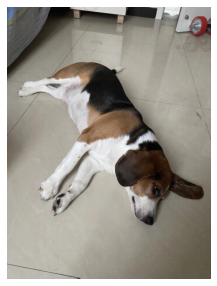

In [122]:
pltshow(toPIL(pgd_wmed))

DCT Processing: 100%|███████████████████████████████████████████████████████████| 34240/34240 [00:07<00:00, 4841.99it/s]


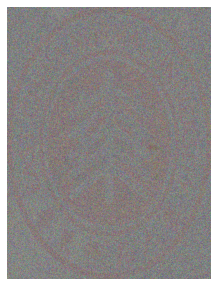

In [123]:
pltshow(toPIL(extract_wm(img_tensor,pgd_wmed,alpha)))

DCT Processing: 100%|███████████████████████████████████████████████████████████| 34240/34240 [00:06<00:00, 5347.48it/s]


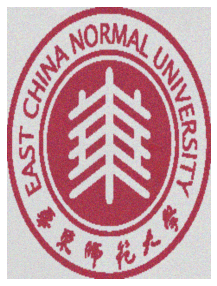

In [125]:
pgd_per = (pgd_wmed-wmed)/beta
per_dct = dct_tensor(pgd_per)

wm_per = per_dct * (beta/alpha)

wm_perturbed = (wm_per+wm_tensor).clip(0,1)

pltshow(toPIL(wm_perturbed))

In [133]:
adv_wm_test = embed_wm(img_tensor,wm_perturbed,alpha)
check_classify(resnet,adv_wm_test)

IDCT Processing: 100%|██████████████████████████████████████████████████████████| 34240/34240 [00:06<00:00, 5148.30it/s]

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(171, device='cuda:0')


DCT Processing: 100%|███████████████████████████████████████████████████████████| 34240/34240 [00:06<00:00, 4973.17it/s]


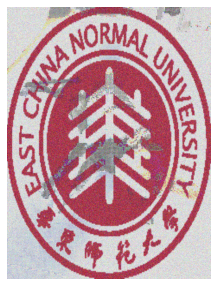

In [134]:
pltshow(toPIL(extract_wm(img_tensor,adv_wm_test,alpha)))

In [147]:
wm_extract = extract_wm(img_tensor,wmed,alpha)

DCT Processing: 100%|███████████████████████████████████████████████████████████| 34240/34240 [00:06<00:00, 5405.81it/s]


In [137]:
wm_adv_origin = extract_wm(img_tensor,pgd_wmed,alpha)

DCT Processing: 100%|███████████████████████████████████████████████████████████| 34240/34240 [00:06<00:00, 5630.51it/s]


In [138]:
wm_adv_new = extract_wm(img_tensor,adv_wm_test,alpha)

DCT Processing: 100%|███████████████████████████████████████████████████████████| 34240/34240 [00:06<00:00, 5002.76it/s]


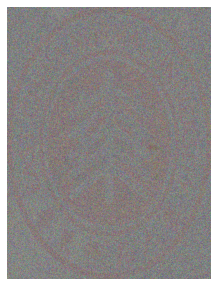

In [139]:
pltshow(toPIL(wm_adv_origin))

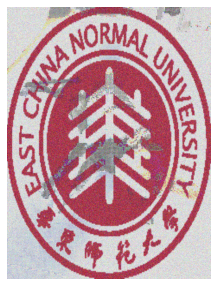

In [140]:
pltshow(toPIL(wm_adv_new))

In [142]:
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, psnr, ssim, fsim,issm,sre,sam,uiq

In [152]:
psnr(wm_adv_new.cpu().numpy(),wm_tensor.cpu().numpy())

82.88221124341922

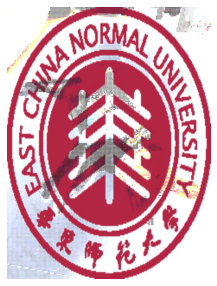

In [148]:
pltshow(toPIL(wm_extract))

In [165]:
from torch import norm
norm(wm_extract-wm_tensor)

tensor(307.5972, device='cuda:0', dtype=torch.float64)

In [166]:
norm(wm_adv_new-wm_tensor)

tensor(753.4611, device='cuda:0', dtype=torch.float64)

In [167]:
norm(wm_adv_origin-wm_tensor)

tensor(991.0914, device='cuda:0', dtype=torch.float64)